In [4]:
import onnx
import onnxruntime as ort
import numpy as np
from numpy import random
import torch
from utils.datasets import LoadStreams, LoadImages
from models.experimental import Ensemble, attempt_load
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from utils.plots import plot_one_box
%matplotlib inline

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
<class 'numpy.ndarray'>


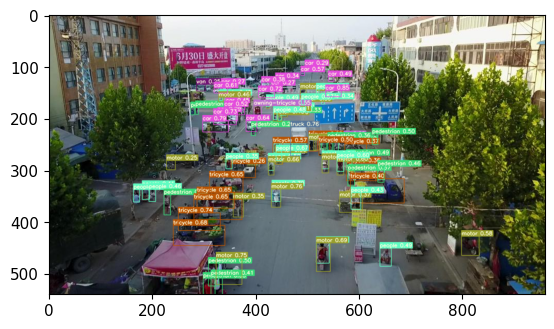

In [8]:
torch_path = 'runs/train/yolov7/weights/best.pt'
device = torch.device("cuda:1")
model = attempt_load(torch_path, map_location=device)  # load FP32 model
stride = int(model.stride.max())
model.eval()

source = "0000364_01765_d_0000782.jpg"
dataset = LoadImages(source, img_size=640, stride=stride)
names = model.module.names if hasattr(model, 'module') else model.names
colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
for path, img, im0s, vid_cap in dataset:
    img = torch.from_numpy(img).to(device)
    img = img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    
    with torch.no_grad():   # Calculating gradients would cause a GPU memory leak
        pred = model(img, augment=False)[0]
        
    pred = non_max_suppression(pred, 0.25, 0.45)
    
    for i, det in enumerate(pred):  # detections per image
        p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)
        gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
        if len(det):
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
            
            # Print results
            for c in det[:, -1].unique():
                n = (det[:, -1] == c).sum()  # detections per class
                s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
            
            # Write results
            for *xyxy, conf, cls in reversed(det):
#                 if save_txt:  # Write to file
#                     xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
#                     line = (cls, *xywh, conf) if opt.save_conf else (cls, *xywh)  # label format
#                     with open(txt_path + '.txt', 'a') as f:
#                         f.write(('%g ' * len(line)).rstrip() % line + '\n')

#                if save_img or view_img:  # Add bbox to image
                label = f'{names[int(cls)]} {conf:.2f}'
                plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=1)
        
        plt.imshow(cv2.cvtColor(im0, cv2.COLOR_RGB2BGR))